In [35]:
import boto3
import os
import json

def extract_text_with_textract(image_path):
    """
    Uses AWS Textract to extract text from an image file.
    Returns a list of detected text lines and the full Textract response.
    """
    try:
        # Initialize the Textract client (Credentials should be configured with `aws configure`).
        textract = boto3.client('textract', region_name='us-east-1')

        # Read the image file as bytes.
        with open(image_path, 'rb') as document:
            image_bytes = document.read()

        # Call Textract to analyze the image.
        response = textract.detect_document_text(Document={'Bytes': image_bytes})

        # Extract text lines.
        text_lines = [block['Text'] for block in response.get('Blocks', []) if block.get('BlockType') == 'LINE']

        return text_lines, response

    except Exception as e:
        print(f"❌ Error extracting text from {image_path}: {e}")
        return [], None  # Return empty list & None to avoid unpacking errors.

def export_text_to_json(text_lines, output_path):
    """
    Saves extracted text to a JSON file.
    """
    try:
        output_data = {"text_lines": text_lines}
        with open(output_path, "w", encoding="utf-8") as f:
            json.dump(output_data, f, indent=4)
        print(f"✅ Exported text to {output_path}")
    except Exception as e:
        print(f"❌ Error writing to JSON file {output_path}: {e}")

def main():
    # Define dataset and output paths.
    dataset_path = r"C:\Users\himan\OneDrive\Desktop\ENERGY7\sip_view_track_map"
    output_folder = os.path.join(dataset_path, "textract_output")
    os.makedirs(output_folder, exist_ok=True)  # Ensure output directory exists.

    # Process each image file in the dataset folder.
    for filename in os.listdir(dataset_path):
        if filename.lower().endswith((".jpg", ".jpeg", ".png", ".pdf")):
            image_path = os.path.join(dataset_path, filename)
            print(f"🔍 Processing: {image_path}...")

            try:
                text_lines, response = extract_text_with_textract(image_path)

                if text_lines:
                    # Save extracted text to JSON file.
                    output_json = os.path.join(output_folder, f"{os.path.splitext(filename)[0]}_text.json")
                    export_text_to_json(text_lines, output_json)

                    # Display extracted text (optional).
                    print("📜 Extracted Text:")
                    for line in text_lines:
                        print(f" - {line}")
                    print("=" * 50)
                else:
                    print(f"⚠️ No text extracted from {filename}")

            except Exception as e:
                print(f"❌ Error processing {filename}: {e}")

if __name__ == "__main__":
    main()


🔍 Processing: C:\Users\himan\OneDrive\Desktop\ENERGY7\sip_view_track_map\Screenshot from 2025-03-28 16-02-42.png...
⚠️ No text extracted from Screenshot from 2025-03-28 16-02-42.png
🔍 Processing: C:\Users\himan\OneDrive\Desktop\ENERGY7\sip_view_track_map\Screenshot from 2025-03-28 16-04-03.png...
✅ Exported text to C:\Users\himan\OneDrive\Desktop\ENERGY7\sip_view_track_map\textract_output\Screenshot from 2025-03-28 16-04-03_text.json
📜 Extracted Text:
 - 514gm
 - 593
 - 124T
 - 177
 - 04AT
 - 04T
 - 104T
 - COLAT
 - CCLBT
 - @@@@
 - AZI
 - SMOOOO
 - 51.000
 - 122/1237
 - t
 - 48AT
 - 258237
 - 25823AT
 - CAST
 - 46T
 - 120T
 - 118T
 - 03AT
 - GST
 - 1037
 - 10ST
 - 110T
 - 12AT
 - +
 - 254297
 - +
 - STAT
 - 1217
 - SIT
 - 119T
 - 02AT
 - 02T
 - +
 - JOT
 - 1147
 - 10ST
 - 102T
 - ST
 - CST
 - 2551867
 - 255167
 - 2008
 - @@@@
 - 552
 - 530
 - SIGN
 - 113T
 - OTAT
 - OIT
 - 106T
 - W 333
🔍 Processing: C:\Users\himan\OneDrive\Desktop\ENERGY7\sip_view_track_map\Screenshot from 2025-03-28

In [148]:
import os
import json
import re
import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# Path Configuration
DATASET_PATH = r"C:\Users\himan\OneDrive\Desktop\ENERGY7\sip_view_track_map"
TEXTRACT_OUTPUT_PATH = r"C:\Users\himan\OneDrive\Desktop\ENERGY7\textract_output"
ANALYSIS_OUTPUT_PATH = os.path.join(DATASET_PATH, "family_analysis")
os.makedirs(ANALYSIS_OUTPUT_PATH, exist_ok=True)

# Processing Parameters
TRACK_ID_PATTERN = r'(?i)\b(\d{2,4}[ST]|STAT|SAT|OUT|SALE)\b'
SIGNAL_TYPES = {'SAT', 'OUT', 'SALE', 'STAT'}
EDGE_LOW_THRESHOLD = 30
EDGE_HIGH_THRESHOLD = 100
MIN_CONNECTION_LENGTH = 20
CONNECTION_THRESHOLD = 50
MAX_CONNECTIONS = 200
DEBUG = True

In [151]:
def load_textract_data(json_path):
    """Load Textract data with error handling"""
    try:
        with open(json_path, 'r') as f:
            data = json.load(f)
        return data.get('text_lines', [])
    except Exception as e:
        if DEBUG: print(f"Error loading {json_path}: {str(e)}")
        return []

def get_valid_images():
    """Get images with valid Textract output"""
    valid = []
    for img in os.listdir(DATASET_PATH):
        if img.lower().endswith((".jpg", ".jpeg", ".png")):
            base_name = os.path.splitext(img)[0]
            json_file = f"{base_name}_text.json"
            if os.path.exists(os.path.join(TEXTRACT_OUTPUT_PATH, json_file)):
                valid.append(img)
    return valid

In [152]:
def extract_track_ids(text_lines):
    """Noise-resistant track ID extraction"""
    ids = []
    noise_terms = {'@@@@', '+++', '...', 'SMOOOO', 'W 333'}
    
    for line in text_lines:
        clean_text = re.sub(r'[^A-Z0-9]', '', str(line).upper())
        if clean_text and clean_text not in noise_terms:
            if re.fullmatch(TRACK_ID_PATTERN, clean_text):
                ids.append(clean_text)
    
    return list(set(ids))

In [153]:
def detect_connections(image_path):
    """Robust connection detection with path resolution"""
    try:
        # Handle JSON path inputs
        if "_text.json" in image_path:
            base = os.path.basename(image_path).replace("_text.json", "")
            image_path = os.path.join(DATASET_PATH, f"{base}.png")
        
        img = cv2.imread(image_path)
        if img is None:
            raise FileNotFoundError(f"Image not found: {image_path}")
        
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        blurred = cv2.GaussianBlur(gray, (5,5), 0)
        edges = cv2.Canny(blurred, EDGE_LOW_THRESHOLD, EDGE_HIGH_THRESHOLD)
        
        lines = cv2.HoughLinesP(edges, 1, np.pi/180, threshold=50,
                              minLineLength=MIN_CONNECTION_LENGTH,
                              maxLineGap=10)
        
        return lines[:MAX_CONNECTIONS] if lines is not None else []
    
    except Exception as e:
        if DEBUG: print(f"Connection error: {str(e)}")
        return []

In [154]:
def map_elements(json_path, image_size):
    """Robust element positioning with connection-based placement"""
    element_map = {}
    try:
        with open(json_path) as f:
            data = json.load(f)
        
        width, height = image_size
        text_lines = data.get('text_lines', [])
        
        # Get connection-based horizontal spread
        img_path = os.path.join(DATASET_PATH, os.path.basename(json_path).replace("_text.json", ".png"))
        connections = detect_connections(img_path)
        x_values = [pt for line in connections[:100] for pt in line[0][::2]]  # All x coordinates
        
        # Calculate average X from connections or use center
        avg_x = int(np.mean(x_values)) if x_values else width // 2
        
        # Vertical spacing based on text line order
        y_step = height // max(1, len(text_lines))
        for i, text in enumerate(text_lines):
            clean_text = re.sub(r'[^A-Z0-9]', '', str(text).upper())
            if re.fullmatch(TRACK_ID_PATTERN, clean_text):
                y = (i + 1) * y_step
                typ = 'signal' if clean_text in SIGNAL_TYPES else 'track'
                element_map[clean_text] = (avg_x, y, typ)
                if DEBUG: print(f"Mapped {clean_text} to ({avg_x}, {y})")
        
        return element_map
    
    except Exception as e:
        if DEBUG: print(f"Mapping error: {str(e)}")
        return {}

In [155]:
def build_families(element_map, connections, img_width, img_height):
    """Family detection with error-safe set operations"""
    graph = defaultdict(set)
    
    # 1. Process connections with list conversion
    for line in connections:
        x1, y1, x2, y2 = line[0]
        endpoints = set()
        
        for elem, (ex, ey, _) in element_map.items():
            if (abs(ex - x1) < CONNECTION_THRESHOLD and 
               abs(ey - y1) < CONNECTION_THRESHOLD):
                endpoints.add(elem)
            if (abs(ex - x2) < CONNECTION_THRESHOLD and 
               abs(ey - y2) < CONNECTION_THRESHOLD):
                endpoints.add(elem)
        
        # Convert to list before indexing
        endpoints = list(endpoints)
        for i in range(len(endpoints)):
            for j in range(i+1, len(endpoints)):
                graph[endpoints[i]].add(endpoints[j])
                graph[endpoints[j]].add(endpoints[i])

    # 2. Connect signals to nearest tracks
    for elem, (ex, ey, etype) in element_map.items():
        if etype == 'signal':
            nearest_track = None
            min_dist = float('inf')
            for track, (tx, ty, ttype) in element_map.items():
                if ttype == 'track':
                    dist = np.hypot(ex-tx, ey-ty)
                    if dist < 2*CONNECTION_THRESHOLD and dist < min_dist:
                        nearest_track = track
                        min_dist = dist
            if nearest_track:
                graph[elem].add(nearest_track)
                graph[nearest_track].add(elem)

    # 3. Find connected components
    families = []
    visited = set()
    for node in graph:
        if node not in visited:
            stack = [node]
            family = []
            while stack:
                current = stack.pop()
                if current not in visited:
                    visited.add(current)
                    family.append(current)
                    stack.extend([n for n in graph[current] if n not in visited])
            families.append(family)
    
    # 4. Add isolated elements
    for elem in element_map:
        if elem not in visited:
            families.append([elem])
    
    return families

In [156]:
def process_image(image_name):
    """Complete image processing workflow"""
    try:
        base_name = os.path.splitext(image_name)[0]
        json_path = os.path.join(TEXTRACT_OUTPUT_PATH, f"{base_name}_text.json")
        image_path = os.path.join(DATASET_PATH, image_name)
        
        # Load and validate data
        text_lines = load_textract_data(json_path)
        if not text_lines:
            print(f"⚠️ Empty Textract data for {image_name}")
            return None
        
        # Process image
        img = cv2.imread(image_path)
        if img is None:
            raise ValueError(f"Invalid image: {image_path}")
        img_height, img_width = img.shape[:2]
        
        # Detect connections
        connections = detect_connections(image_path)
        if DEBUG: print(f"Detected {len(connections)} connections")
        
        # Map elements
        element_map = map_elements(json_path, (img_width, img_height))
        if not element_map:
            print("⚠️ No elements mapped")
            return None
        
        # Build families
        families = build_families(element_map, connections, img_width, img_height)
        
        # Prepare output
        output = {
            "image": image_name,
            "elements": {k: list(v) for k, v in element_map.items()},  # Convert for JSON
            "families": families,
            "connection_count": len(connections)
        }
        
        # Save results
        output_file = os.path.join(ANALYSIS_OUTPUT_PATH, f"{base_name}_analysis.json")
        with open(output_file, 'w') as f:
            json.dump(output, f, indent=2)
        
        return output
    
    except Exception as e:
        print(f"❌ Processing failed: {str(e)}")
        return None

In [157]:
def visualize_results(image_name, results):
    """Robust visualization with coordinate validation"""
    try:
        img_path = os.path.join(DATASET_PATH, image_name)
        img = cv2.imread(img_path)
        if img is None:
            raise ValueError(f"Image not found: {img_path}")
        
        vis_img = img.copy()
        height, width = vis_img.shape[:2]
        
        # Draw elements with validation
        for elem, elem_data in results['elements'].items():
            try:
                # Convert to integers and clamp values
                x = int(float(elem_data[0]))
                y = int(float(elem_data[1]))
                x = max(20, min(x, width - 20))
                y = max(20, min(y, height - 20))
                
                typ = elem_data[2] if len(elem_data) > 2 else 'track'
                color = (0, 0, 255) if typ == 'signal' else (255, 0, 0)
                
                cv2.circle(vis_img, (x, y), 15, color, -1)
                cv2.putText(vis_img, elem, (x + 20, y), 
                          cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)
            except Exception as e:
                if DEBUG: print(f"⚠️ Skipping {elem}: {str(e)}")

        # Add status overlay
        cv2.putText(vis_img, f"Tracks: {len(results['elements'])}", (20, 40),
                   cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
        cv2.putText(vis_img, f"Families: {len(results['families'])}", (20, 80),
                   cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
        cv2.putText(vis_img, f"Connections: {results['connection_count']}", (20, 120),
                   cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)

        # Display results
        plt.figure(figsize=(18, 12))
        plt.imshow(cv2.cvtColor(vis_img, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title(f"Analysis: {image_name}")
        plt.show()
    
    except Exception as e:
        print(f"Visualization error: {str(e)}")

Starting processing...
Processing 4 images:

Processing Screenshot from 2025-03-28 16-04-03.png...
Detected 91 connections
Mapped 124T to (704, 30)
Mapped 04T to (704, 60)
Mapped 104T to (704, 70)
Mapped 46T to (704, 200)
Mapped 120T to (704, 210)
Mapped 118T to (704, 220)
Mapped 110T to (704, 270)
Mapped STAT to (704, 320)
Mapped 119T to (704, 350)
Mapped 02T to (704, 370)
Mapped 102T to (704, 420)
Mapped 113T to (704, 520)
Mapped 106T to (704, 550)
✅ Mapped 13 elements


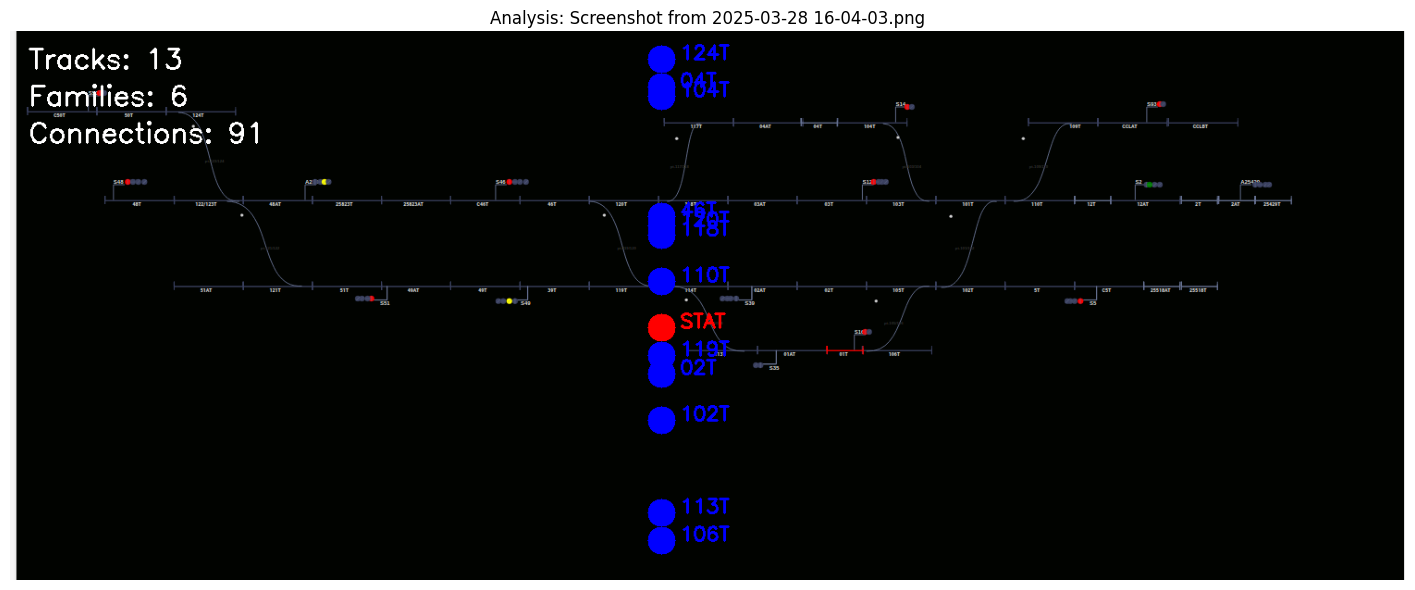


Processing Screenshot from 2025-03-28 16-04-54.png...
Detected 168 connections
Mapped 62S to (1034, 72)
✅ Mapped 1 elements


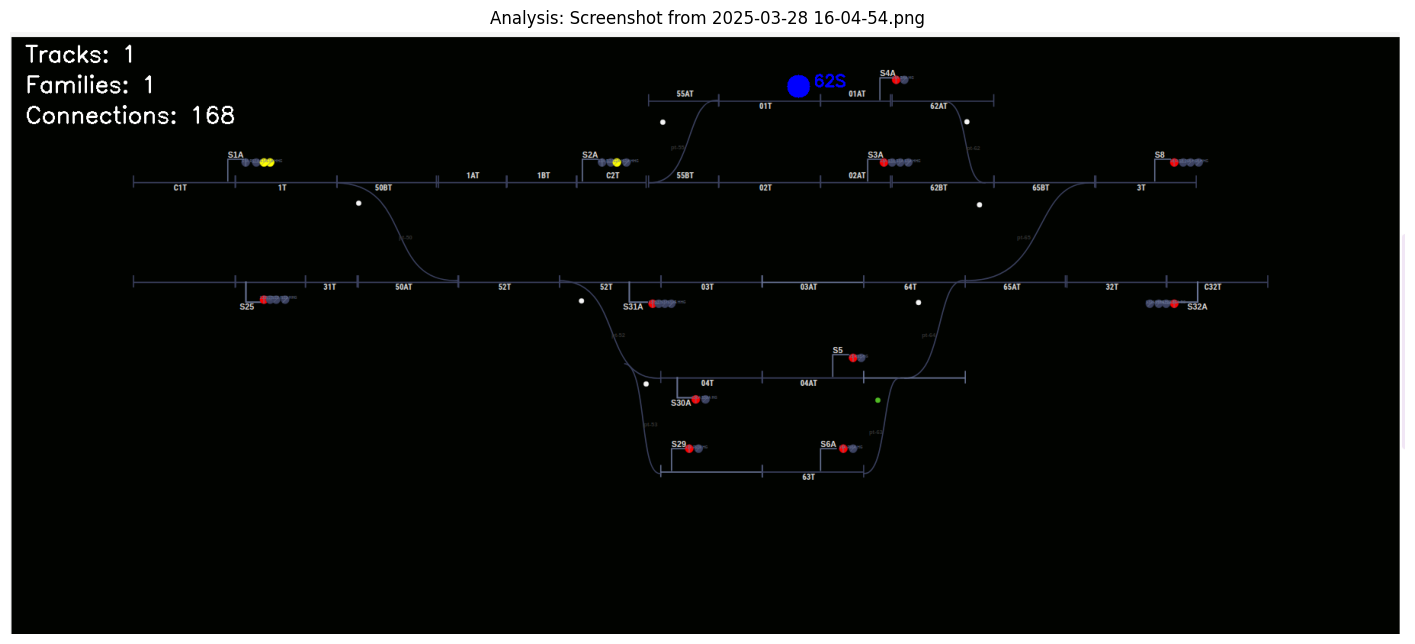


Processing Screenshot from 2025-03-28 16-05-21.png...
Detected 200 connections
Mapped 03T to (1025, 162)
Mapped 115T to (1025, 180)
Mapped 101T to (1025, 360)
Mapped 130T to (1025, 369)
Mapped 131T to (1025, 378)
Mapped 02T to (1025, 423)
Mapped 116T to (1025, 441)
Mapped 39T to (1025, 450)
Mapped 49T to (1025, 468)
Mapped 154T to (1025, 486)
Mapped 159T to (1025, 495)
Mapped 01T to (1025, 549)
Mapped 128T to (1025, 558)
Mapped 160T to (1025, 567)
Mapped 129T to (1025, 576)
Mapped 46T to (1025, 585)
Mapped 62T to (1025, 621)
Mapped 127T to (1025, 720)
✅ Mapped 18 elements


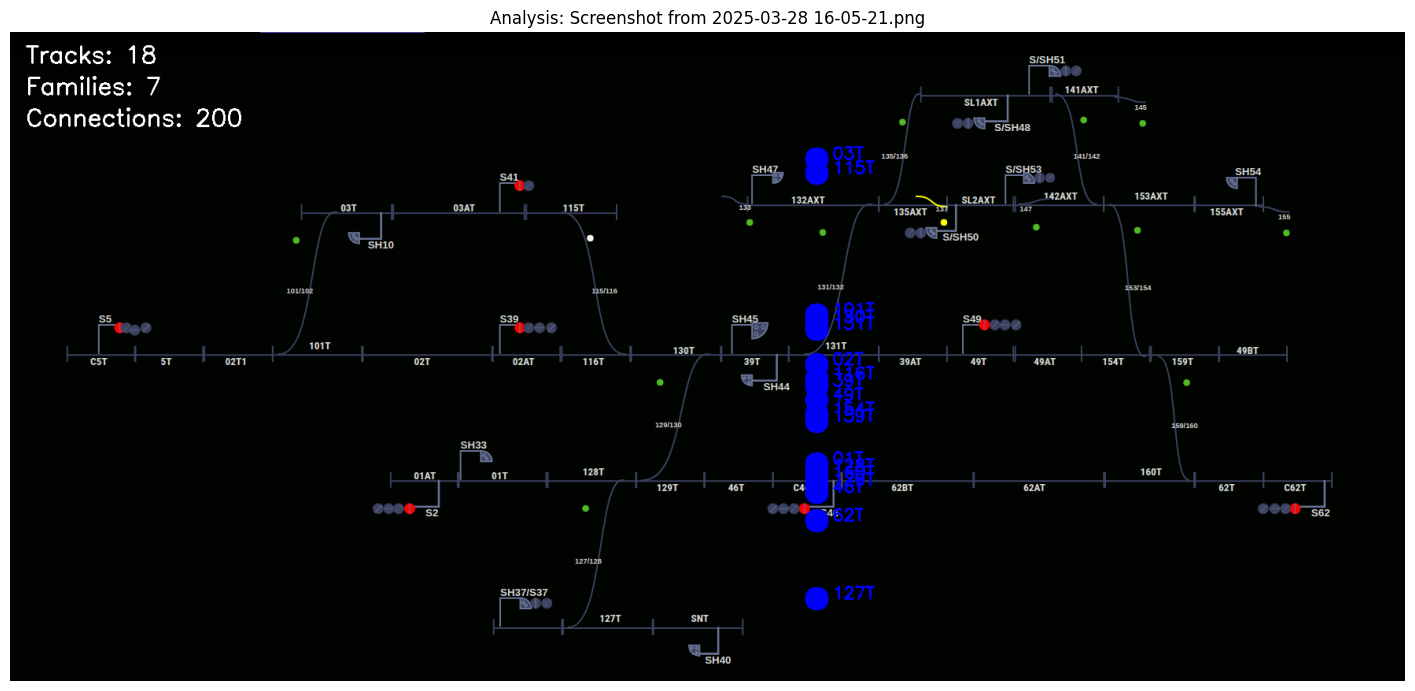


Processing Screenshot from 2025-03-28 16-05-38.png...
Detected 200 connections
Mapped 04T to (866, 85)
Mapped 03T to (866, 306)
Mapped 13T to (866, 391)
Mapped 107T to (866, 442)
Mapped 62T to (866, 459)
Mapped 107T to (866, 493)
Mapped 02T to (866, 527)
Mapped 116T to (866, 561)
Mapped 70T to (866, 578)
Mapped 01T to (866, 765)
✅ Mapped 9 elements


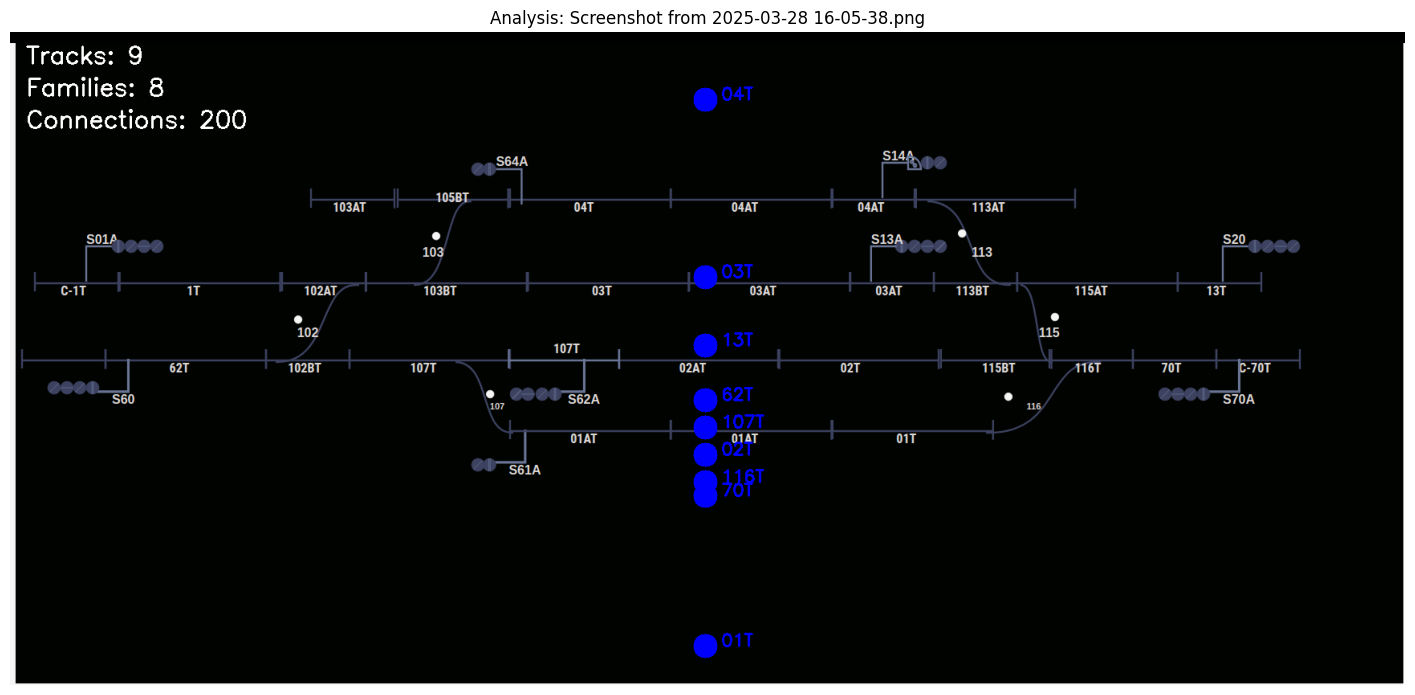


Processing complete! Success: 4/4


In [158]:
print("Starting processing...")
valid_images = get_valid_images()
if not valid_images:
    print("No valid images found. Check:")
    print(f"1. Textract files in {TEXTRACT_OUTPUT_PATH}")
    print(f"2. Images in {DATASET_PATH}")
else:
    print(f"Processing {len(valid_images)} images:")
    
    success_count = 0
    for img_name in valid_images:
        print(f"\n{'='*40}\nProcessing {img_name}...")
        try:
            result = process_image(img_name)
            if result and result.get('elements'):
                print(f"✅ Mapped {len(result['elements'])} elements")
                visualize_results(img_name, result)
                success_count += 1
            else:
                print("❌ No elements mapped")
        except Exception as e:
            print(f"❌ Critical error: {str(e)}")
    
    print(f"\nProcessing complete! Success: {success_count}/{len(valid_images)}")

In [160]:
# Execute this in a Jupyter cell after loading all code
process_image("Screenshot from 2025-03-28 16-04-03.png")

Detected 91 connections
Mapped 124T to (704, 30)
Mapped 04T to (704, 60)
Mapped 104T to (704, 70)
Mapped 46T to (704, 200)
Mapped 120T to (704, 210)
Mapped 118T to (704, 220)
Mapped 110T to (704, 270)
Mapped STAT to (704, 320)
Mapped 119T to (704, 350)
Mapped 02T to (704, 370)
Mapped 102T to (704, 420)
Mapped 113T to (704, 520)
Mapped 106T to (704, 550)


{'image': 'Screenshot from 2025-03-28 16-04-03.png',
 'elements': {'124T': [704, 30, 'track'],
  '04T': [704, 60, 'track'],
  '104T': [704, 70, 'track'],
  '46T': [704, 200, 'track'],
  '120T': [704, 210, 'track'],
  '118T': [704, 220, 'track'],
  '110T': [704, 270, 'track'],
  'STAT': [704, 320, 'signal'],
  '119T': [704, 350, 'track'],
  '02T': [704, 370, 'track'],
  '102T': [704, 420, 'track'],
  '113T': [704, 520, 'track'],
  '106T': [704, 550, 'track']},
 'families': [['120T', '104T', '46T', '118T', '04T'],
  ['119T', '02T', 'STAT', '110T'],
  ['124T'],
  ['102T'],
  ['113T'],
  ['106T']],
 'connection_count': 91}

In [159]:
# Temporary cell to check JSON structure
sample_json = os.path.join(TEXTRACT_OUTPUT_PATH, "Screenshot from 2025-03-28 16-04-03_text.json")
with open(sample_json) as f:
    print(json.dumps(json.load(f), indent=2))

{
  "text_lines": [
    "514gm",
    "593",
    "124T",
    "177",
    "04AT",
    "04T",
    "104T",
    "COLAT",
    "CCLBT",
    "@@@@",
    "AZI",
    "SMOOOO",
    "51.000",
    "122/1237",
    "t",
    "48AT",
    "258237",
    "25823AT",
    "CAST",
    "46T",
    "120T",
    "118T",
    "03AT",
    "GST",
    "1037",
    "10ST",
    "110T",
    "12AT",
    "+",
    "254297",
    "+",
    "STAT",
    "1217",
    "SIT",
    "119T",
    "02AT",
    "02T",
    "+",
    "JOT",
    "1147",
    "10ST",
    "102T",
    "ST",
    "CST",
    "2551867",
    "255167",
    "2008",
    "@@@@",
    "552",
    "530",
    "SIGN",
    "113T",
    "OTAT",
    "OIT",
    "106T",
    "W 333"
  ]
}


In [121]:
# Temporary cell
test_ids = ["124T", "STAT", "2551867", "@@@@"]
print([id for id in test_ids if re.fullmatch(TRACK_ID_PATTERN, id)])
# Should output: ['124T', 'STAT']

['124T', 'STAT']


In [165]:
def extract_track_numbers(results, sort_by='x'):

    track_data = []
    
    if not results or not results.get('elements'):
        print("No results to process")
        return []
    
    for track_id, data in results['elements'].items():
        try:
            x = data[0]
            y = data[1]
            track_data.append((track_id, (x, y)))
        except (IndexError):
            print(f"⚠️ Couldn't parse track data from {track_id}")
    
    # Sort tracks spatially or alphabetically by track_id
    if sort_by.lower() == 'x':
        # Horizontal sorting (left to right)
        track_data.sort(key=lambda item: (item[1][0], item[1][1]))
    elif sort_by.lower() == 'y':
        # Vertical sorting (top to bottom)
        track_data.sort(key=lambda item: (item[1][1], item[1][0]))
    else:
        # Default alphabetical sorting by track_id
        track_data.sort(key=lambda item: item[0])
    
    return track_data

result = process_image("Screenshot from 2025-03-28 16-04-03.png")
if result:
    tracks = extract_track_numbers(result, sort_by='x')
    print("\nTrack Layout:")
    for track_id, (x, y) in tracks:
        print(f"Track {track_id}: Position ({x}, {y})")


Detected 91 connections
Mapped 124T to (704, 30)
Mapped 04T to (704, 60)
Mapped 104T to (704, 70)
Mapped 46T to (704, 200)
Mapped 120T to (704, 210)
Mapped 118T to (704, 220)
Mapped 110T to (704, 270)
Mapped STAT to (704, 320)
Mapped 119T to (704, 350)
Mapped 02T to (704, 370)
Mapped 102T to (704, 420)
Mapped 113T to (704, 520)
Mapped 106T to (704, 550)

Track Layout:
Track 124T: Position (704, 30)
Track 04T: Position (704, 60)
Track 104T: Position (704, 70)
Track 46T: Position (704, 200)
Track 120T: Position (704, 210)
Track 118T: Position (704, 220)
Track 110T: Position (704, 270)
Track STAT: Position (704, 320)
Track 119T: Position (704, 350)
Track 02T: Position (704, 370)
Track 102T: Position (704, 420)
Track 113T: Position (704, 520)
Track 106T: Position (704, 550)
